In [20]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

from transforms import *
import albumentations as A

In [22]:
# from architectures import *
# model = ClassificationModel(
#     classification_model='swin_base_patch4_window12_384',
#     in_chans=2,
#     num_classes=1,
#     custom_preprocess='chris_debias',
#     custom_classifier='avg',
# )
# model = SegmentationAndClassification(
#     segmentation_model='timm-efficientnet-b0',
#     classification_model='tf_efficientnet_b0_ns',
#     in_chans=2,
#     num_classes=1,
#     custom_preprocess='chris_debias',
#     custom_classifier='avg',
#     return_mask=True
# )

# model(torch.empty((2, 2, 352, 640)))[1].shape

In [23]:
df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = df.loc[df['target'] != -1]

torch.Size([3, 360, 512])


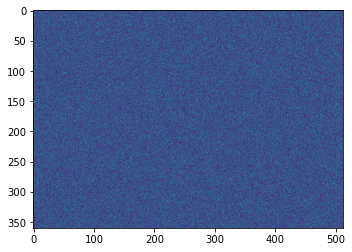

In [24]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transforms import *

ds = G2Net2022Dataset(
    test, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    # match_time=True,
    spec_diff=True,
    resize_factor=8, 
    transforms=A.Compose([
        # A.Resize(360, 1024), 
        ShiftImage(x_max=100, y_max=100, p=1.0),
        RandomCrop(512),
        ToTensorV2(), 
        # FrequencyMaskingTensor(p=1.0), 
        # TimeMaskingTensor(128, p=1.0),
        # FrequencyMaskingTensor(p=1.0),
        ]),
    normalize='laeyoung')
for i in range(20):
    data = ds[i][0]
    print(data.shape)
    # plt.imshow(data.permute(1,2,0)[:, :1000])
    plt.imshow(ds[i][0][0, :, :1000])
    plt.show()
    break

# Get metadata

In [ ]:
# signal_summary = []
# ds = G2Net2022Dataset(df, resize_factor=4, )
# for idx in tqdm(range(len(df))):
#     try:
#         spec_h1, spec_l1 = ds[idx][0]
#     except:
#         print(f'ERROR: {idx}')
#         continue
#     signal_summary.append({
#         'idx': idx,
#         'h1_mean': spec_h1.mean().item(),
#         'h1_max': spec_h1.max().item(),
#         'h1_min': spec_h1.min().item(),
#         'l1_mean': spec_l1.mean().item(),
#         'l1_max': spec_l1.max().item(),
#         'l1_min': spec_l1.min().item()
#     })
# signal_summary = pd.DataFrame(signal_summary)


In [ ]:
# signal_summary.describe()

In [ ]:
# def count_gaps(timestamps, Tsft=1800):
#     gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
#     return (gap_length > 0).sum()

In [ ]:
# signal_summary = []
# for gid in tqdm(df['id'].values[:100]):
#     fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/train/{gid}.pickle')
#     # with h5py.File(fname, 'r') as f:
#     with open(fname, 'rb') as fp:
#         f = pickle.load(fp)
#         freq = list(f[gid]['frequency_Hz'])
#         sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
#         sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
#         sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
#         sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
#         ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
#         ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
#         signal_summary.append({
#             'idx': gid,
#             'ts_start_h1': ts_start_h1,
#             'ts_end_h1': ts_end_h1,
#             'num_gaps_h1': count_gaps(time_h1),
#             'length_h1': len(time_h1),
#             'max_h1': np.max(sig_h1),
#             '90%_h1': np.percentile(sig_h1, 90),
#             '25%_h1': np.percentile(sig_h1, 25),
#             '10%_h1': np.percentile(sig_h1, 10),
#             'ts_start_l1': ts_start_l1,
#             'ts_end_l1': ts_end_l1,
#             'num_gaps_l1': count_gaps(time_l1),
#             'length_l1': len(time_l1),
#             'max_l1': np.max(sig_l1),
#             '90%_l1': np.percentile(sig_l1, 90),
#             '25%_l1': np.percentile(sig_l1, 25),
#             '10%_l1': np.percentile(sig_l1, 10),
#         })
# signal_summary = pd.DataFrame(signal_summary)
# signal_summary.describe()

In [ ]:
# signal_summary = []
# for gid in tqdm(test['id']):
#     fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
#     with open(fname, 'rb') as fp:
#         f = pickle.load(fp)
#         freq = list(f[gid]['frequency_Hz'])
#         sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
#         sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
#         sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
#         sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
#         ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
#         ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
#         signal_summary.append({
#             'idx': gid,
#             'ts_start_h1': ts_start_h1,
#             'ts_end_h1': ts_end_h1,
#             'num_gaps_h1': count_gaps(time_h1),
#             'length_h1': len(time_h1),
#             'max_h1': np.max(sig_h1),
#             '90%_h1': np.percentile(sig_h1, 90),
#             '25%_h1': np.percentile(sig_h1, 25),
#             '10%_h1': np.percentile(sig_h1, 10),
#             'ts_start_l1': ts_start_l1,
#             'ts_end_l1': ts_end_l1,
#             'num_gaps_l1': count_gaps(time_l1),
#             'length_l1': len(time_l1),
#             'max_l1': np.max(sig_l1),
#             '90%_l1': np.percentile(sig_l1, 90),
#             '25%_l1': np.percentile(sig_l1, 25),
#             '10%_l1': np.percentile(sig_l1, 10),
#         })
# signal_summary = pd.DataFrame(signal_summary)
# signal_summary.describe()

In [ ]:
# signal_summary.to_csv('input/signal_summary.csv', index=False)

In [118]:
signal_stat = {}
# for gid in ['228955f70']:
for gid in tqdm(test['id']):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = f[gid]['frequency_Hz']
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        spec_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        spec_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        asd_h1_time, std_h1 = spec_h1.mean(0), spec_h1.std(0)
        asd_l1_time, std_l1 = spec_l1.mean(0), spec_l1.std(0)
        asd_h1_freq = spec_h1.mean(1)
        asd_l1_freq = spec_l1.mean(1)
        signal_stat[gid] = {}
        signal_stat[gid]['H1'] = (asd_h1_time, asd_h1_freq, time_h1)
        signal_stat[gid]['L1'] = (asd_l1_time, asd_l1_freq, time_l1)
        signal_stat[gid]['freq'] = freq

  0%|          | 0/7975 [00:00<?, ?it/s]

In [6]:
# with open('input/signal_stat.pickle', 'wb') as f:
#     pickle.dump(signal_stat, f)

with open('input/signal_stat.pickle', 'rb') as f:
    signal_stat = pickle.load(f)

In [7]:
signal_stat_stat = []
for k, v in signal_stat.items():
    signal_stat_stat.append({
        'id': k,
        'H1_asd_mean': v['H1'][0].mean(),
        'H1_asd_std': v['H1'][0].std(),
        'H1_asd_median': np.percentile(v['H1'][0], 50),
        'H1_asd_max': v['H1'][0].max(),
        'H1_asd_median_freq': np.percentile(v['H1'][1], 50),
        'H1_asd_max_freq': v['H1'][1].max(),
        'L1_asd_mean': v['L1'][0].mean(),
        'L1_asd_std': v['L1'][0].std(),
        'L1_asd_max': v['L1'][0].max(),
        'L1_asd_median': np.percentile(v['L1'][0], 50),
        'L1_asd_max_freq': v['L1'][1].max(),
        'L1_asd_median_freq': np.percentile(v['L1'][1], 50),
    })
signal_stat_stat = pd.DataFrame(signal_stat_stat)

In [9]:
from transforms import adaptive_resize

def load_test_spec(gid):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        spec_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        spec_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
    return spec_h1, spec_l1


def resize_image(img, img_size):
    return adaptive_resize(img[:, :, None], img_size, np.mean)[:, :, 0]


def extract_artifact(spec, n_sigma=8):
    spec_std = spec.std()
    spec_min = spec.min()
    amp_map = (spec - spec_min) / spec_std
    artifact_map = amp_map > n_sigma
    return artifact_map


def reconstruct_from_stat(mean_arr):
    spec = np.zeros((360, len(mean_arr)), dtype=np.float32)
    for t, mean in enumerate(mean_arr):
        spec[:, t] = np.random.chisquare(2, 360)
        factor = mean / spec[:, t].mean()
        spec[:, t] *= factor
    return spec


def generate_from_stat(gid, signal_stat, artifact_sigma=8):
    metadata = {
        'id': gid, 
        'nonstationary_H1': False, 
        'nonstationary_L1': False,
        'artifact_H1': False, 
        'artifact_L1': False,
    }
    asd_time_h1, asd_freq_h1, time_h1 = signal_stat[gid]['H1']
    asd_time_l1, asd_freq_l1, time_l1 = signal_stat[gid]['L1']
    freqs = signal_stat[gid]['freq']
    if asd_time_h1.max() > 3:
        metadata['nonstationary_H1'] = True
    if asd_time_l1.max() > 3:
        metadata['nonstationary_L1'] = True
    if asd_freq_h1.max() > 5 or asd_freq_h1.max() > 5:
        metadata['nonstationary_H1'] = True
        spec_gen_h1 = reconstruct_from_stat(asd_time_h1.clip(0, 10))
        spec_org = load_test_spec(gid)[0]
        artifact_map = extract_artifact(spec_org, artifact_sigma)
        spec_gen_h1[np.where(artifact_map)] = spec_org[np.where(artifact_map)]
    else:
        spec_gen_h1 = reconstruct_from_stat(asd_time_h1.clip(0, 10))
    if asd_freq_l1.max() > 5 or asd_freq_l1.max() > 5:
        metadata['nonstationary_L1'] = True
        spec_gen_l1 = reconstruct_from_stat(asd_time_l1.clip(0, 10))
        spec_org = load_test_spec(gid)[1]
        artifact_map = extract_artifact(spec_org, artifact_sigma)
        spec_gen_l1[np.where(artifact_map)] = spec_org[np.where(artifact_map)]
    else:
        spec_gen_l1 = reconstruct_from_stat(asd_time_l1.clip(0, 10))
    return {
        'H1': {
            'spectrogram': spec_gen_h1,
            'timestamps': time_h1,
        }, 
        'L1': {
            'spectrogram': spec_gen_l1,
            'timestamps': time_l1,
        },
        'frequency': freqs
    }


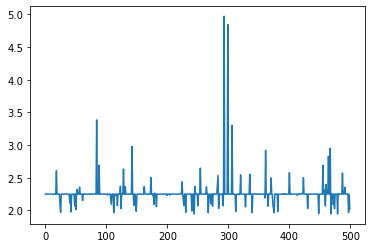

In [10]:
plt.plot(signal_stat_stat['L1_asd_mean'].clip(0, 5).iloc[:500])

In [11]:
signal_stat_stat['H1_max_median_ratio'] = signal_stat_stat['H1_asd_max'] / signal_stat_stat['H1_asd_median']
signal_stat_stat['H1_max_median_ratio_freq'] = signal_stat_stat['H1_asd_max_freq'] / signal_stat_stat['H1_asd_median_freq']
signal_stat_stat['L1_max_median_ratio'] = signal_stat_stat['L1_asd_max'] / signal_stat_stat['L1_asd_median']
signal_stat_stat['L1_max_median_ratio_freq'] = signal_stat_stat['L1_asd_max_freq'] / signal_stat_stat['L1_asd_median_freq']

In [12]:
# signal_stat_stat.query('10 < H1_asd_max or 10 < L1_asd_max') # Query for non-time-consistent artifact
# signal_stat_stat.query('10 < H1_asd_max_freq or 10 < H1_max_median_ratio_freq') # Query for time-consistent artifact

artifact_test = signal_stat_stat.query('10 < H1_asd_max or 10 < L1_asd_max or 10 < H1_asd_max_freq or 10 < H1_max_median_ratio_freq') # Query for time-consistent artifact

In [13]:
signal_stat_stat

,id,H1_asd_mean,H1_asd_std,H1_asd_median,H1_asd_max,H1_asd_median_freq,H1_asd_max_freq,L1_asd_mean,L1_asd_std,L1_asd_max,L1_asd_median,L1_asd_max_freq,L1_asd_median_freq,H1_max_median_ratio,H1_max_median_ratio_freq,L1_max_median_ratio,L1_max_median_ratio_freq
0,00054c878,2.251315,0.118761,2.253212,2.698138,2.251550,2.350245,2.247697,0.120393,2.676944,2.245868,2.339644,2.247718,1.197463,1.043834,1.191942,1.040898
1,0007285a3,2.249648,0.118474,2.247805,2.757737,2.248661,2.358919,2.253814,0.119022,2.659317,2.253208,2.366923,2.253304,1.226858,1.049033,1.180236,1.050423
2,00076c5a6,2.249535,0.118194,2.246204,2.655239,2.248962,2.345180,2.250063,0.118636,2.667745,2.248820,2.383590,2.248833,1.182101,1.042783,1.186287,1.059923
3,001349290,2.251041,0.118517,2.249992,2.676809,2.249067,2.377609,2.251271,0.119876,2.749345,2.248053,2.353629,2.251383,1.189697,1.057154,1.222989,1.045415
4,001a52e92,2.250895,0.119663,2.250525,2.661041,2.250123,2.346444,2.249981,0.119231,2.765754,2.246825,2.358841,2.251568,1.182409,1.042807,1.230961,1.047644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7970,ffbce04ef,2.245802,0.117858,2.243596,2.687692,2.246334,2.329053,2.250713,0.118611,2.823246,2.248490,2.332948,2.252020,1.197940,1.036824,1.255619,1.035936
7971,ffc2d976b,2.247059,0.117080,2.245968,2.701608,2.246920,2.345719,2.252228,0.116468,2.745701,2.249779,2.356481,2.252927,1.202871,1.043971,1.220431,1.045964
7972,ffc905909,2.249271,0.117814,2.245618,2.681393,2.250696,2.339463,2.253107,0.118931,2.749691,2.250246,2.347795,2.252644,1.194056,1.039440,1.221951,1.042240
7973,ffe276f3e,2.249999,0.118203,2.247597,2.727818,2.248194,2.343063,2.249995,0.119038,2.690517,2.246475,2.339591,2.246579,1.213660,1.042198,1.197662,1.041402


In [79]:
artifact_test.head()

,id,H1_asd_mean,H1_asd_std,H1_asd_median,H1_asd_max,H1_asd_median_freq,H1_asd_max_freq,L1_asd_mean,L1_asd_std,L1_asd_max,L1_asd_median,L1_asd_max_freq,L1_asd_median_freq,H1_max_median_ratio,H1_max_median_ratio_freq,L1_max_median_ratio,L1_max_median_ratio_freq
18,006e25113,4.634546,0.819849,4.419677,10.960500,4.631757,4.858927,2.606079,0.313672,5.102825,2.560694,2.710314,2.608277,2.479932,1.049046,1.992751,1.039120
84,025517630,3.113863,0.325220,3.108540,4.624075,3.113476,3.232817,3.384949,0.652561,11.590537,3.286339,6.393273,3.187577,1.487539,1.038331,3.526885,2.005684
102,02efaba20,2.843643,0.571504,2.732774,10.361210,2.842143,2.965214,2.234568,0.215226,3.528144,2.213850,2.334676,2.234815,3.791462,1.043302,1.593669,1.044685
142,040b35321,4.259747,0.490842,4.181184,10.042527,4.226187,5.244284,2.978835,0.381952,5.621714,2.899087,3.120907,2.980692,2.401838,1.240902,1.939132,1.047041
285,097b1ada1,2.813012,0.886600,2.779662,42.282982,2.811155,2.957663,2.202306,0.254045,4.266692,2.158389,2.302330,2.202760,15.211557,1.052117,1.976795,1.045202


In [15]:
for gid in artifact_test['id'].values:
    plt.figure(figsize=(12, 4))
    spec1, spec2 = load_test_spec(gid)
    plt.subplot(1, 2, 1)
    plt.imshow(resize_image(spec1, 720))
    plt.subplot(1, 2, 2)
    plt.imshow(resize_image(spec2, 720))
    plt.suptitle(f'{gid}')
    plt.savefig(f'input/plot/anomaly/{gid}.png', facecolor='white')
    # plt.show()
    plt.close()


In [24]:
# for gid in signal_stat_stat.query('2.9 < H1_asd_max < 3.0')['id'].values[:5]:
#     plt.figure(figsize=(12, 4))
#     spec1, spec2 = load_test_spec(gid)
#     plt.subplot(1, 2, 1)
#     plt.imshow(resize_image(spec1, 720))
#     plt.subplot(1, 2, 2)
#     plt.imshow(resize_image(spec2, 720))
#     plt.suptitle(f'{gid}')
#     # plt.savefig(f'input/plot/anomaly/{gid}.png', facecolor='white')
#     plt.show()
#     plt.close()

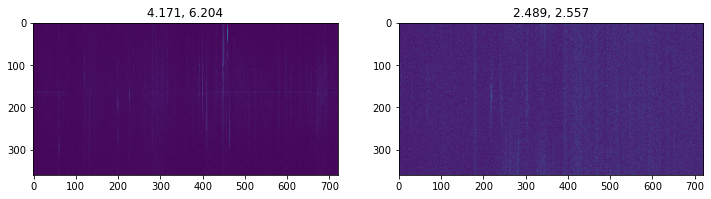

In [116]:
img_h1, img_l1 = load_test_spec('24b8f38a9')
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_image(img_h1, 720))
plt.title(f'{img_h1.mean():.3f}, {img_h1.std():.3f}')
plt.subplot(1, 2, 2)
plt.imshow(resize_image(img_l1, 720))
plt.title(f'{img_l1.mean():.3f}, {img_l1.std():.3f}')
plt.show()

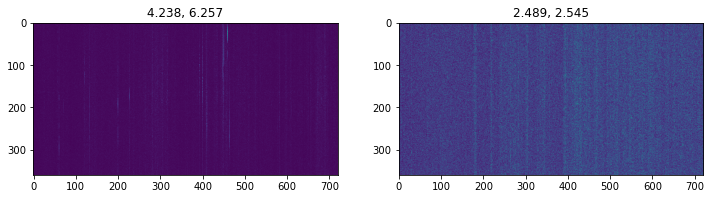

In [14]:
data_gen = generate_from_stat('24b8f38a9', signal_stat=signal_stat, artifact_sigma=5)
img_h1 = data_gen['H1']['spectrogram']
img_l1 = data_gen['L1']['spectrogram']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(resize_image(img_h1, 720))
plt.title(f'{img_h1.mean():.3f}, {img_h1.std():.3f}')
plt.subplot(1, 2, 2)
plt.imshow(resize_image(img_l1, 720))
plt.title(f'{img_l1.mean():.3f}, {img_l1.std():.3f}')
plt.show()

In [19]:
data_gen['H1']['timestamps'].dtype

dtype('int64')

# Wave generation

In [ ]:
import math
import pyfstat
from pyfstat.utils import get_sft_as_arrays
from transforms import adaptive_resize
import shutil
from prep_data_v18v import NoPrint, bucketize_real_noise_asd, TEST_DIR, C_SQRSX

DATASET = 'v18v'

C_SQRSX = 26.6
REF_SX = 5e-24
F1_MIN, F1_MAX = -12, -8 # new sampling
DP_MIN, DP_MID, DP_MAX = 20, 35, 50
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')


def to_spectrogram(sfts):
    return sfts.real ** 2 + sfts.imag ** 2


def extract_artifact(spec):
    spec_std = spec.std()
    spec_min = spec.min()
    amp_map = (spec - spec_min) / spec_std
    artifact_map = amp_map > 10
    return artifact_map


def mix_artifact(sft1, sft2, artifact_map):
    assert sft2.shape == artifact_map.shape
    assert sft2.shape[0] == sft1.shape[0]
    if sft2.shape[1] > sft1.shape[1]:
        artifact_map = artifact_map[:, :sft1.shape[1]]
        sft2 = sft2[:, :sft1.shape[1]]
        sft1[artifact_map] = sft2[artifact_map]
    else:
        sft1[np.where(artifact_map)] = sft2[np.where(artifact_map)]
    return sft1
 

def make_data(gid, num_buckets=128, target='negative'):
    PROJ_DIR = Path(f'input/g2net-detecting-continuous-gravitational-waves/template_{num_buckets}/{gid}')
    PROJ_DIR.mkdir(parents=True, exist_ok=True)
    TMP_DIR = Path(f'pyfstat_tmp_{DATASET}/{gid}/')
    # load test data
    with open(TEST_DIR/f'{gid}.pickle', 'rb') as f:
        test = pickle.load(f)
        sft_h1, ts_h1 = test[gid]['H1']['SFTs'], test[gid]['H1']['timestamps_GPS']
        sft_l1, ts_l1 = test[gid]['L1']['SFTs'], test[gid]['L1']['timestamps_GPS']
        freqs = test[gid]['frequency_Hz']

    artifact_h1 = extract_artifact(to_spectrogram(sft_h1*1e22))
    artifact_l1 = extract_artifact(to_spectrogram(sft_l1*1e22))

    asd_h1, bs_h1 = bucketize_real_noise_asd(sft_h1, ts_h1, num_buckets)
    asd_l1, bs_l1 = bucketize_real_noise_asd(sft_l1, ts_l1, num_buckets)
    
    with NoPrint():
        noise_kwargs_h1 = {
            "outdir": str(TMP_DIR),
            "Tsft": 1800,
            "F0": np.mean(freqs),
            # "F0": freqs[0],
            "detectors": "H1",
            "SFTWindowType": "tukey",
            "SFTWindowBeta": 0.1,
            "Band": 0.4,
            "duration": bs_h1,
        }
        if (PROJ_DIR/'sft_list_h1.csv').exists():
            sft_paths_h1 = pd.read_csv(PROJ_DIR/'sft_list_h1.csv')['path'].tolist()
        else:
            tmp_paths = []
            sft_paths_h1 = []
            for segment in range(num_buckets):
                args = noise_kwargs_h1.copy()
                args["label"] = f"h1_segment_{segment}"
                args["sqrtSX"] = asd_h1[segment] / C_SQRSX
                args["tstart"] = ts_h1[0] + segment * bs_h1
                writer = pyfstat.Writer(**args)
                writer.make_data()
                tmp_paths.append(writer.sftfilepath)
            for path in tmp_paths:
                shutil.move(Path(path), PROJ_DIR)
                sft_paths_h1.append(str(PROJ_DIR/Path(path).name))
            pd.DataFrame({'path': sft_paths_h1}).to_csv(PROJ_DIR/'sft_list_h1.csv', index=False)

        if (PROJ_DIR/'sft_list_l1.csv').exists():
            sft_paths_l1 = pd.read_csv(PROJ_DIR/'sft_list_l1.csv')['path'].tolist()
        else:
            noise_kwargs_l1 = noise_kwargs_h1.copy()
            noise_kwargs_l1["detectors"] = "L1"
            noise_kwargs_l1["duration"] = bs_l1
            tmp_paths = []
            sft_paths_l1 = []
            for segment in range(num_buckets):
                args = noise_kwargs_l1.copy()
                args["label"] = f"l1_segment_{segment}"
                args["sqrtSX"] = asd_l1[segment] / C_SQRSX
                args["tstart"] = ts_l1[0] + segment * bs_l1
                writer = pyfstat.Writer(**args)
                writer.make_data()
                tmp_paths.append(writer.sftfilepath)
            for path in tmp_paths:
                shutil.move(Path(path), PROJ_DIR)
                sft_paths_l1.append(str(PROJ_DIR/Path(path).name))
            shutil.rmtree(TMP_DIR)
            pd.DataFrame({'path': sft_paths_l1}).to_csv(PROJ_DIR/'sft_list_l1.csv', index=False)
    
    if target == 'negative':
        signal_depth = 1000
        freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(";".join(sorted(sft_paths_h1)))
        freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(";".join(sorted(sft_paths_l1)))
    else:
        with NoPrint():
            signal_kwargs = {
                "outdir": str(TMP_DIR),
                "label": f'h1_signal',
                "F0": np.mean(freqs),
                "F1": np.random.choice([-1, 1]) * (10 ** np.random.uniform(F1_MIN, F1_MAX)),
                "F2": 0,
                "Alpha": np.random.uniform(0, math.pi * 2),
                "Delta": np.random.uniform(-math.pi/2, math.pi/2),
                # "h0": noise_kwargs_h1['sqrtSX'] / signal_depth,
                "cosi": np.random.uniform(-1, 1),
                "psi": np.random.uniform(-math.pi/4, math.pi/4),
                "phi": np.random.uniform(0, math.pi*2),
                "SFTWindowType": "tukey",
            }
            if target == 'strong': # 
                signal_depth = np.random.uniform(DP_MIN, DP_MID)
            elif target == 'weak': 
                signal_depth = np.random.uniform(DP_MID, DP_MAX)

            # H1
            signal_variety = np.random.uniform(0.95, 1.05)
            signal_kwargs['label'] = f'h1_signal'
            signal_kwargs['h0'] = REF_SX * signal_variety / signal_depth
            signal_kwargs['noiseSFTs'] = ";".join(sorted(sft_paths_h1))
            writer = pyfstat.Writer(**signal_kwargs)
            writer.make_data()
            freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer.sftfilepath)
            # L1
            signal_variety = np.random.uniform(0.95, 1.05)
            signal_kwargs['label'] = f'l1_signal'
            signal_kwargs['h0'] = REF_SX * signal_variety / signal_depth
            signal_kwargs['noiseSFTs'] = ";".join(sorted(sft_paths_l1))
            writer = pyfstat.Writer(**signal_kwargs)
            writer.make_data()
            freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(writer.sftfilepath)
            shutil.rmtree(TMP_DIR)

    ref_time = min(ts_h1.min(), ts_l1.min())
    frame_h1 = ((ts_h1 - ref_time) / 1800).round().astype(np.uint64)
    frame_l1 = ((ts_l1 - ref_time) / 1800).round().astype(np.uint64)

    times = {
        'H1': ts_h1[frame_h1 < sft_data_h1['H1'].shape[1]], 
        'L1': ts_l1[frame_l1 < sft_data_l1['L1'].shape[1]]}
    sft_data = {
        'H1': sft_data_h1['H1'][:, frame_h1[frame_h1 < sft_data_h1['H1'].shape[1]]], 
        'L1': sft_data_l1['L1'][:, frame_l1[frame_l1 < sft_data_l1['L1'].shape[1]]]}
    # slice_start = np.random.randint(75, 285)
    slice_start = 0
    sft_crop = {}
    for d in ['H1', 'L1']: # crop
        sft_crop[d] = sft_data[d][slice_start:slice_start+360]

    sft_crop['H1'] = mix_artifact(sft_crop['H1'], sft_h1, artifact_h1)
    sft_crop['L1'] = mix_artifact(sft_crop['L1'], sft_l1, artifact_l1)
    return sft_crop, times, None



def make_signal(depth):
    writer_kwargs = {
        "outdir": 'pyfstat',
        "label": 'signal',
        "tstart": 1238166018,
        "duration": 4 * 32 * 86400,
        "detectors": "H1",
        "sqrtSX": 0,
        "Tsft": 1800,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": 0.01,
        "Band": 0.2
    }
    signal_kwargs = {
        "F0": np.random.uniform(50, 500),
        "F1": np.random.choice([-1, 1]) * (10 ** np.random.uniform(F1_MIN, F1_MAX)),
        "F2": 0,
        "Alpha": np.random.uniform(0, math.pi * 2),
        "Delta": np.random.uniform(-math.pi/2, math.pi/2),
        "h0": 5e-24 / depth,
        "cosi": np.random.uniform(-1, 1),
        "psi": np.random.uniform(-math.pi/4, math.pi/4),
        "phi": np.random.uniform(0, math.pi*2),
      
    }
    writer = pyfstat.Writer(**writer_kwargs, **signal_kwargs)
    writer.make_data()
    freq, ts, sft = get_sft_as_arrays(writer.sftfilepath)
    return sft

In [ ]:
data, ts, debug = make_data('3c451363c', 16)
spec_h1, spec_l1 = to_spectrogram(data['H1']*1e22), to_spectrogram(data['L1']*1e22)
time_h1, time_l1 = ts['H1'], ts['L1']
print(spec_h1.shape, spec_l1.shape)

In [ ]:
with open('input/g2net-detecting-continuous-gravitational-waves/test/fc0e2d950.pickle', 'rb') as f:
    data2 = pickle.load(f)['fc0e2d950']
spec_h1_test = to_spectrogram(data2['H1']['SFTs']*1e22)

In [ ]:
# plt.imshow(adaptive_resize(spec_h1_test[:, :, None], 360, np.mean))

In [ ]:
spec_h1.mean(), spec_h1_test.mean()

In [ ]:
spec_h1.std(), spec_h1_test.std()

In [ ]:
signal_spec = to_spectrogram(sft['H1']*1e22)

In [ ]:
signal_spec = adaptive_resize(signal_spec[:, :, None], 360, np.mean)[:, :, 0]

In [ ]:
with open('input/g2net-detecting-continuous-gravitational-waves/v18v_lite/fc0e2d950_weak.pickle', 'rb') as f:
    data = pickle.load(f)
with open('input/g2net-detecting-continuous-gravitational-waves/test/fc0e2d950.pickle', 'rb') as f:
    data2 = pickle.load(f)['fc0e2d950']

In [ ]:
# plt.figure(figsize=(8, 4))
# spec_h1, spec_l1 = to_spectrogram(data2['H1']['SFTs']*1e22), to_spectrogram(data2['L1']['SFTs']*1e22)
# time_h1, time_l1 = data2['H1']['timestamps_GPS'], data2['L1']['timestamps_GPS']
# _spec = np.full((2, 360, 5760), 0., np.float32)
# ref_time = min(time_h1.min(), time_l1.min())
# frame_h1 = ((time_h1 - ref_time) / 1800).round().astype(np.uint64)
# frame_l1 = ((time_l1 - ref_time) / 1800).round().astype(np.uint64)
# _spec[0][:, frame_h1[frame_h1 < 5760]] = spec_h1[:, frame_h1 < 5760]
# _spec[1][:, frame_l1[frame_l1 < 5760]] = spec_l1[:, frame_l1 < 5760]
# spec_h1, spec_l1 = _spec[0], _spec[1]
# plt.subplot(1, 2, 1)
# plt.imshow(adaptive_resize(spec_h1[:, :, None], 360, np.mean))
# plt.subplot(1, 2, 2)
# plt.imshow(adaptive_resize(spec_l1[:, :, None], 360, np.mean))
# plt.show()

In [ ]:
# plt.figure(figsize=(8, 4))
# spec_h1, spec_l1 = data['H1']['spectrogram'], data['L1']['spectrogram']
# time_h1, time_l1 = data['H1']['timestamps'], data['L1']['timestamps']
# _spec = np.full((2, 360, 5760), 0., np.float32)
# ref_time = min(time_h1.min(), time_l1.min())
# frame_h1 = ((time_h1 - ref_time) / 1800).round().astype(np.uint64)
# frame_l1 = ((time_l1 - ref_time) / 1800).round().astype(np.uint64)
# _spec[0][:, frame_h1[frame_h1 < 5760]] = spec_h1[:, frame_h1 < 5760]
# _spec[1][:, frame_l1[frame_l1 < 5760]] = spec_l1[:, frame_l1 < 5760]
# spec_h1, spec_l1 = _spec[0], _spec[1]
# plt.subplot(1, 2, 1)
# plt.imshow(adaptive_resize(spec_h1[:, :, None], 360, np.mean))
# plt.subplot(1, 2, 2)
# plt.imshow(adaptive_resize(spec_l1[:, :, None], 360, np.mean))
# plt.show()

In [ ]:

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(adaptive_resize(data['H1']['spectrogram'][:, :, None], 360, np.mean).clip(0, 4.0))
plt.subplot(1, 2, 2)
plt.imshow(adaptive_resize(data['L1']['spectrogram'][:, :, None], 360, np.mean).clip(0, 4.0))
plt.show()

In [ ]:
from scipy.signal import istft

In [ ]:
for _ in range(100):
    _, waveform = istft(test_signal, nperseg=2)

In [ ]:
plt.plot(waveform*1e23)

In [ ]:
# trns = A.Compose([ToSpectrogram(), AdaptiveResize(8)])
# sft = trns(image=sft['H1'][:, :, None])['image']
# plt.imshow(sft)

# Model

In [ ]:
# from replknet import create_RepLKNet31B, create_RepLKNet31L
# from kuma_utils.torch.utils import fit_state_dict
# import torch

In [ ]:
# model = create_RepLKNet31B(in_chans=2, num_classes=1)

In [ ]:
# checkpoint = torch.load('input/RepLKNet-31B_ImageNet-22K-to-1K_384.pth')
# fit_state_dict(checkpoint, model)
# model.load_state_dict(checkpoint, strict=False)